# Preprocessing #
Evan Petrimoulx\
Sania Palaha\
Data Analytics 1

In [1]:
import os
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from skimage import color
from matplotlib.image import imread
from numpy.fft import fft2, fftshift
from scipy.fft import fftshift

In [2]:
image_pixel_array = [] 
filename = []
Type = []
is_healthy = []
plant_name = []
for folder in os.listdir('Plant_leave_diseases_dataset_without_augmentation'):
    if folder.endswith(".DS_Store"):
        continue
    for file in os.listdir('Plant_leave_diseases_dataset_without_augmentation/' + folder):
        if file.endswith(".JPG"):
            filename.append(folder + '_' + file)
            image = imread('Plant_leave_diseases_dataset_without_augmentation/' + folder + '/' + file)
            image = Image.fromarray(image)
            image = image.resize((64, 64))
            image_pixel_array.append(image)
            plant_name.append(folder.partition("___")[0])
        if "___healthy" in folder:
            is_healthy.append(True)
            Type.append("Healthy")
        else:
            is_healthy.append(False)
            Type.append(folder.partition("___")[2])
   
image_pixel_array = np.array(image_pixel_array)

Dataset is now loaded and stored as a 3D numpy array (image, (horizontal pixels, vertical pixels)). Now we can perform the data preprocessing, and store the dataset.

### Fourier Transform Feature ###

(52803, 64, 64, 3)


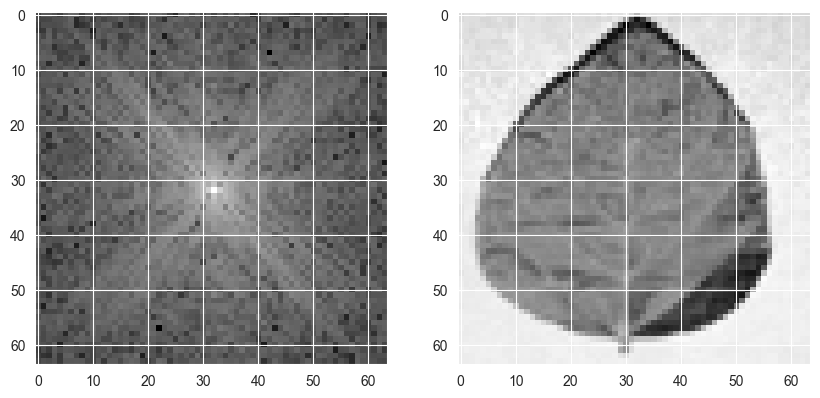

In [3]:
# Fourier Transform Information
Fourier_Data = []
Fourier_Data_Real = []
Fourier_Data_Imag = []
mean_frequency = []
variance_frequency = []
num_images = image_pixel_array.shape[0]

print(image_pixel_array.shape)

for image in range(num_images):
    grayscale_image = color.rgb2gray(image_pixel_array[image]) # Convert to greyscale
    image_FT = fftshift(fft2(fftshift(grayscale_image))) # Compute 2D Fourier Transform
    Fourier_Data.append(image_FT)    
    mean_frequency.append(Fourier_Data[image].mean())
    variance_frequency.append(np.var(Fourier_Data[image]))
    
Fourier_Data_Real = np.real(Fourier_Data)
Fourier_Data_Imag = np.imag(Fourier_Data)
mean_frequency_real = np.real(mean_frequency)
mean_frequency_imaginary = np.imag(mean_frequency)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(Fourier_Data[-1])), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(grayscale_image, cmap='gray')
plt.show()

### Contrast Enhancement ###

(52803, 64, 64, 3)


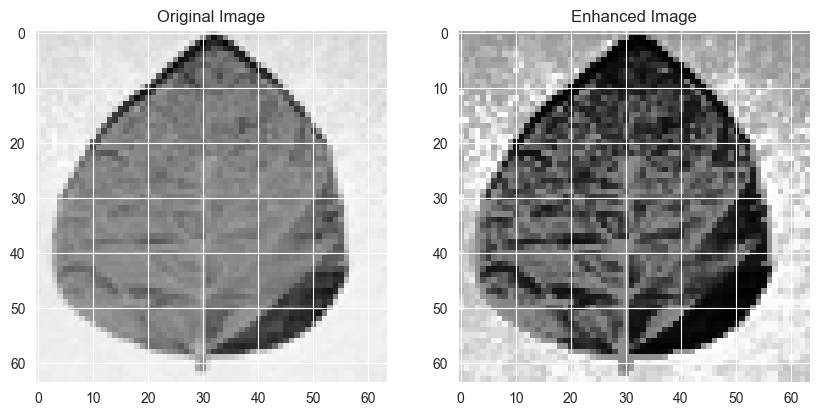

In [4]:
# Using CLAHE - Adaptive Histogram Equalization
enhanced_images = []
contrast_std = []
min_intensity = []
max_intensity = []
num_images = image_pixel_array.shape[0]

print(image_pixel_array.shape)

for image in range(num_images):
    grayscale_image = color.rgb2gray(image_pixel_array[image]) # Convert to greyscale
    enhanced_image = cv.equalizeHist((grayscale_image * 255).astype(np.uint8)) # Enhance contrast by applying histogram equalization
    enhanced_images.append(enhanced_image) # Append enhanced image to list
    contrast_std.append(np.std(grayscale_image))
    min_intensity.append(np.min(grayscale_image))
    max_intensity.append(np.max(grayscale_image))
    
    

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(grayscale_image, cmap='gray') # Show original grayscale image
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(enhanced_images[-1], cmap='gray') # Show contrast-enhanced image
plt.title("Enhanced Image")
plt.show()

### Noise Reduction ###

(52803, 64, 64, 3)


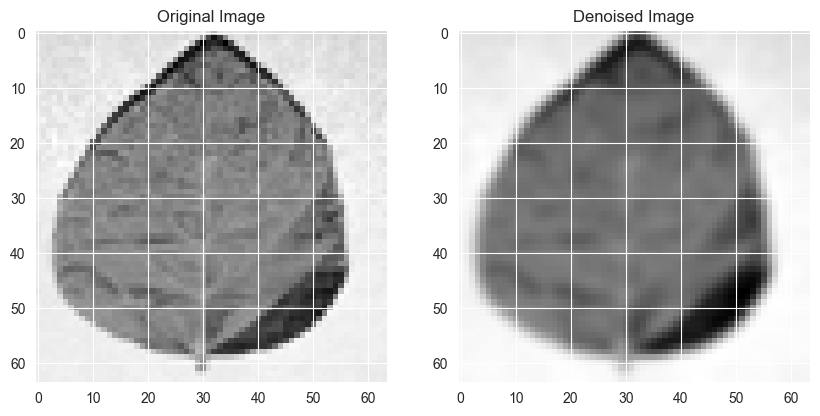

In [5]:
denoised_images = []
mean_noise = []
std_noise = []
num_images = image_pixel_array.shape[0]

print(image_pixel_array.shape)

for image in range(num_images):
    grayscale_image = color.rgb2gray(image_pixel_array[image]) # Convert to greyscale
    denoised_image = cv.GaussianBlur(grayscale_image, (5, 5), 0) # Apply Gaussian blur for noise reduction
    denoised_images.append(denoised_image) # Append denoised image to list
    mean_noise.append(np.mean(grayscale_image))
    std_noise.append(np.std(grayscale_image))
    

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(grayscale_image, cmap='gray') # Show original grayscale image
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(denoised_images[-1], cmap='gray') # Show denoised image
plt.title("Denoised Image")
plt.show()

### Edge Detection ###

(52803, 64, 64, 3)


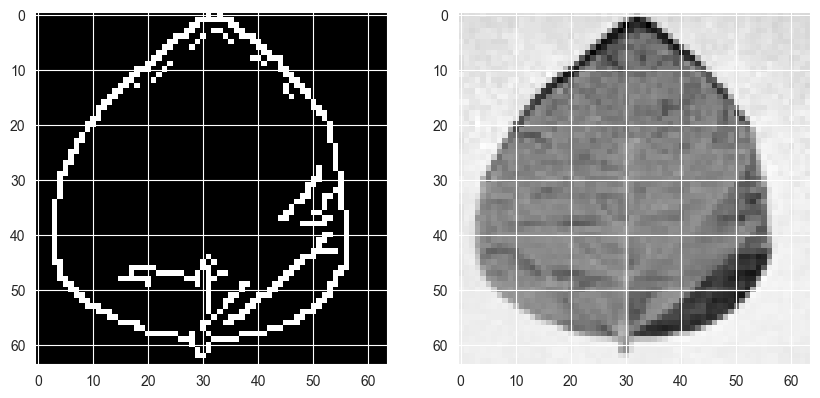

In [6]:
Edges = []
num_edges = []
num_images = image_pixel_array.shape[0]

print(image_pixel_array.shape)

for image in range(num_images):
    gray_image = color.rgb2gray(image_pixel_array[image])  # Convert to grayscale
    gray_image = (gray_image * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
    edges = cv.Canny(gray_image, 100, 220)
    Edges.append(edges)  
    num_edges.append(np.sum(edges > 0))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(Edges[-1], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.show()

### Combining Into Overall Dataframe ###

In [7]:
Plant_Data = []

for image in range(num_images):
    print(f"Appending Disease Label: {Type[image]}")
    Plant_Data.append([
        num_edges[image],
        mean_frequency_real[image],
        mean_frequency_imaginary[image],
        variance_frequency[image],
        contrast_std[image],
        mean_noise[image],
        std_noise[image],
        min_intensity[image],
        max_intensity[image],
        is_healthy[image],
        Type[image],
    ])

feature_names = ['Edge_Count', 'Re(Mean_Frequency)', 'Im(Mean_Frequency)', 'Frequency_Variance', 'StDev_Contrast', 'Mean_Noise', 'StDev_Noise', 'Minimum_Intensity', 'Maximum_Intensity', 'Is_Healthy', 'Disease']

Plant_Dataset = pd.DataFrame(Plant_Data, columns=feature_names)
Plant_Dataset.index = filename
Plant_Dataset.to_csv('Feature_Extracted_Plant_Dataset.csv', index=filename)

Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending Disease Label: Healthy
Appending 

In [8]:
Plant_Dataset.describe()

,Edge_Count,Re(Mean_Frequency),Im(Mean_Frequency),Frequency_Variance,StDev_Contrast,Mean_Noise,StDev_Noise,Minimum_Intensity,Maximum_Intensity
count,52803.000000,52803.000000,5.280300e+04,52803.000000,52803.000000,52803.000000,52803.000000,52803.000000,52803.000000
mean,441.175104,0.432590,-4.128050e-20,1043.109380,0.142318,0.476966,0.142318,0.085437,0.753024
std,190.125086,0.133243,2.009960e-17,301.178560,0.042527,0.071808,0.042527,0.062764,0.094796
min,0.000000,0.000848,-1.665335e-16,163.408944,0.029202,0.131723,0.029202,0.000000,0.367933
25%,289.000000,0.342362,-1.387779e-17,842.672999,0.111821,0.430708,0.111821,0.040853,0.688573
50%,420.000000,0.436709,0.000000e+00,1006.582372,0.140735,0.474295,0.140735,0.069160,0.758271
75%,581.000000,0.522776,1.387779e-17,1191.774667,0.169974,0.516459,0.169974,0.115961,0.820833
max,1569.000000,0.981226,1.110223e-16,3588.441038,0.363226,0.925371,0.363226,0.575310,1.000000


In [9]:
Plant_Dataset

,Edge_Count,Re(Mean_Frequency),Im(Mean_Frequency),Frequency_Variance,StDev_Contrast,Mean_Noise,StDev_Noise,Minimum_Intensity,Maximum_Intensity,Is_Healthy,Disease
Strawberry___healthy_image (326).JPG,617,0.242427,-5.551115e-17,1002.236841,0.160643,0.467862,0.160643,0.062738,0.851704,True,Healthy
Strawberry___healthy_image (263).JPG,554,0.623920,-5.204170e-18,1146.240778,0.126150,0.513834,0.126150,0.084050,0.830714,True,Healthy
Strawberry___healthy_image (371).JPG,425,0.437348,6.938894e-18,1067.863428,0.082776,0.503889,0.082776,0.112356,0.795260,True,Healthy
Strawberry___healthy_image (234).JPG,665,0.528069,-6.938894e-18,1351.819154,0.165402,0.550222,0.165402,0.091572,0.829660,True,Healthy
Strawberry___healthy_image (408).JPG,563,0.291719,-2.602085e-17,1287.161794,0.150021,0.540151,0.150021,0.058779,0.763842,True,Healthy
...,...,...,...,...,...,...,...,...,...,...,...
Soybean___healthy_image (1650).JPG,295,0.453402,1.214306e-17,1117.685165,0.155154,0.498848,0.155154,0.152874,0.812315,True,Healthy
Soybean___healthy_image (427).JPG,260,0.376838,1.040834e-17,1346.686564,0.186381,0.542289,0.186381,0.068564,0.804962,True,Healthy
Soybean___healthy_image (4901).JPG,374,0.484486,3.469447e-17,1689.968878,0.191896,0.613044,0.191896,0.124910,0.919544,True,Healthy
Soybean___healthy_image (974).JPG,275,0.335510,1.040834e-17,1352.862842,0.144110,0.556371,0.144110,0.261004,0.773405,True,Healthy


In [10]:
print(Plant_Dataset['Disease'].unique())

['Healthy' 'Black_rot' 'Early_blight' 'Powdery_mildew' 'Target_Spot'
 'Late_blight' 'Tomato_mosaic_virus' 'Haunglongbing_(Citrus_greening)'
 'Leaf_Mold' 'Leaf_blight_(Isariopsis_Leaf_Spot)' 'Cedar_apple_rust'
 'Bacterial_spot' 'Cercospora_leaf_spot Gray_leaf_spot'
 'Esca_(Black_Measles)' 'Northern_Leaf_Blight'
 'Tomato_Yellow_Leaf_Curl_Virus' 'Apple_scab'
 'Spider_mites Two-spotted_spider_mite' 'Common_rust' 'Septoria_leaf_spot'
 'Leaf_scorch']


#### Split Data into a per-plant Basis ####

In [11]:
Individual_Plant_Datasets = Plant_Dataset
Individual_Plant_Datasets['Plant_Name'] = plant_name
Individual_Plant_Datasets = {plant: df for plant, df in Individual_Plant_Datasets.groupby("Plant_Name")}

output_folder = "Individual Plant Datasets"
os.makedirs(output_folder, exist_ok=True)

for plant, df in Individual_Plant_Datasets.items():
    df.drop(columns=["Plant_Name"], inplace=True)
    file_path = os.path.join(output_folder, f"{plant}.csv")
    df.to_csv(file_path, index=True)


In [12]:
print(Individual_Plant_Datasets.keys())

dict_keys(['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato'])
